# Stree view house number

In this tutorial, we done 2 modifies:
1. AdaptiveConcatPool2d((1,1)) => AdaptiveConcatPool2d((2,2)). That don't drop to much information by pooling.
2. Add number information in to model. (Data loader, Header, Lost functions will be modified)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.plots import *
import pandas as pd
from fastai.conv_learner import *
from fastai.dataset import *

In [3]:
ls /fast/data/SVHN

extra/            models/          test.tar.gz      train_length.csv
extra_boxes.csv   test/            tmp/             train.tar.gz
extra.csv         test_boxes.csv   train/
extra_length.csv  test.csv         train_boxes.csv
extra.tar.gz      test_length.csv  train.csv


In [4]:
home_dir = '/fast/data/SVHN/'

In [5]:
train_df = pd.read_csv(os.path.join(home_dir, 'train.csv'))

In [6]:
max([len(l.split(' ')) for l in list(train_df.tags)])

6

In [7]:
train_df.sample(3)

,image_name,tags
28449,5540,1 2
8950,18053,5 8
9948,18952,8 10


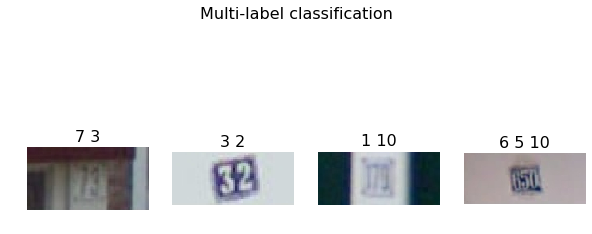

In [8]:
samples = train_df.sample(4)
list_paths = [f"{home_dir}train/{i}.png" for i in list(samples['image_name'])]
titles=list(samples['tags'])
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [9]:
f_model = resnet34

In [10]:
label_csv = os.path.join(home_dir, 'train.csv')
bb_csv = os.path.join(home_dir, 'train_boxes.csv')
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n, val_pct=0.2)

In [11]:
train_df = pd.read_csv(label_csv)
train_df['tags'] = train_df.tags.apply(lambda x: [int(i) if int(i) != 10 else 0 for i in x.split(' ')])

In [12]:
((val_label,trn_label),) = split_by_idx(val_idxs, train_df)

In [13]:
def get_data(sz, bs=30):
    aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD), 
                RandomStretch(max_stretch=0.5, tfm_y=TfmType.COORD),
               ]
    tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
    return ImageClassifierData.from_csv(home_dir, 'train', bb_csv, tfms=tfms, bs=bs, 
                                        suffix='.png', val_idxs=val_idxs, test_name='test',
                                        continuous=True, num_workers=4)

In [14]:
sz = 64
data = get_data(64)

In [15]:
x, y = data.trn_ds[0]

In [16]:
x.shape, y

((3, 64, 64), array([ 9., 21., 59., 27.,  9., 28., 59., 35.], dtype=float32))

In [17]:
y

array([ 9., 21., 59., 27.,  9., 28., 59., 35.], dtype=float32)

In [18]:
from matplotlib import patches, patheffects
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def get_big_bounding_box(boxes):
    # top, left, bottom, right
    return np.array([min(boxes[:, 0]), min(boxes[:,1]), max(boxes[:, 2]), max(boxes[:, 3])])

def draw_im(im, boxes, cats, draw_one_box=False):
    ax = show_img(im, figsize=(8,4))
    if draw_one_box:
        b = bb_hw(boxes)
        draw_rect(ax, b)
    else:
        for b, c in zip(boxes, cats):
            b = bb_hw(b)
            draw_rect(ax, b)
            draw_text(ax, b[:2], c, sz=16)

In [19]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, labels, sz):
        self.ds,self.labels = ds,labels
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        boxes = y.reshape((-1, 4))
        box = get_big_bounding_box(boxes) / sz
        return (x, ((len(self.labels[i])-1), box, np.array(self.labels[i])))

In [20]:
len(trn_label), len(val_label)

(26722, 6680)

In [21]:
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [22]:
x, y = data.trn_ds[4]
print(x.shape, y)

(3, 64, 64) (2, array([0.26562, 0.34375, 0.875  , 0.60938], dtype=float32), array([1, 5, 3]))


(1, array([0.0625 , 0.29688, 0.78125, 0.6875 ], dtype=float32), array([2, 4]))


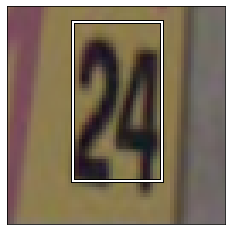

In [23]:
x, y = data.trn_ds[108]
img = data.val_ds.ds.denorm(to_np(x))[0]
boxes = y[1] * sz
draw_im(img, boxes, y[1], draw_one_box=True)
print(y)

In [24]:
class CountHead(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.adaptive = AdaptiveConcatPool2d((2,2))
        self.flatten = Flatten()
        self.layer1 = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(n, 1024), nn.BatchNorm1d(1024), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU())
        self.layer31 = nn.Sequential(nn.Linear(512, 6))
        self.layer32 = nn.Sequential(nn.Linear(512, 4), nn.Sigmoid())
        self.layer33 = nn.Linear(512, 10 * 6)
    def forward(self, x):
        out = self.adaptive(x)
        out = self.flatten(out)
        out = self.layer1(out)
        out = self.layer2(out)
        label = self.layer31(out)
        box = self.layer32(out)
        nums = self.layer33(out).reshape(-1, 6, 10)
        return [label, box, nums]

In [25]:
def custome_accuracy(input:list, targs:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    input = input[0]
    targs = targs[0]
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

def num_accuracy(pred:list, labels:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n_sample = 0.0
    true_case = 0.0
    n_nums = pred[0].argmax(dim=1) + 1
    batch_size = pred[N_NUMBER_INDEX].shape[0]
    for i in range(batch_size):
        n_sample += 1
        pred_num = int(''.join([str(j.item()) for j in pred[NUMBER_INDEX][i][-n_nums[i]:].argmax(dim=1)]))
        true_num = int(''.join([str(j.item()) for j in labels[NUMBER_INDEX][i]]))
        if pred_num == true_num:
            true_case += 1
    return true_case / n_sample

In [26]:
count_head = CountHead(1024 * 4)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=count_head)
learn = ConvLearner(data, models, metrics=[custome_accuracy, num_accuracy])
learn.opt_fn = optim.Adam

In [27]:
count_head

CountHead(
  (adaptive): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=(2, 2))
    (mp): AdaptiveMaxPool2d(output_size=(2, 2))
  )
  (flatten): Flatten()
  (layer1): Sequential(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer31): Sequential(
    (0): Linear(in_features=512, out_features=6, bias=True)
  )
  (layer32): Sequential(
    (0): Linear(in_features=512, out_features=4, bias=True)
    (1): Sigmoid()
  )
  (layer33): Linear(in_features=512, out_features=60, bias=True)
)

In [28]:
images, labels = next(iter(data.trn_dl))

In [29]:
images.shape, labels[0].shape, labels[1].shape, labels[2].shape

(torch.Size([30, 3, 64, 64]),
 torch.Size([30]),
 torch.Size([30, 4]),
 torch.Size([30, 4]))

In [30]:
pred = learn.model(images)

In [31]:
pred[2].shape

torch.Size([30, 6, 10])

In [32]:
pred[0].shape, pred[1].shape, pred[2].shape

(torch.Size([30, 6]), torch.Size([30, 4]), torch.Size([30, 6, 10]))

In [33]:
labels[0]

tensor([1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2,
        2, 1, 1, 0, 2, 0], device='cuda:0')

In [34]:
NUMBER_INDEX = 2
N_NUMBER_INDEX= 0

In [35]:
class MSECustomize(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss()
        self.num_loss = nn.CrossEntropyLoss()
        self.box_loss = nn.L1Loss()
    def forward(self, pred, targ):
        batch_size = pred[N_NUMBER_INDEX].shape[0]
        num_loss = sum([self.num_loss(pred[NUMBER_INDEX][i][-(targ[N_NUMBER_INDEX][i] + 1):], targ[NUMBER_INDEX][i][-(targ[N_NUMBER_INDEX][i] + 1):]) for i in range(batch_size)])/ batch_size
        return 2 * num_loss + self.loss(pred[0], targ[0]) + 10 * self.box_loss(pred[1], targ[1]) 

In [36]:
learn.crit = MSECustomize()

In [37]:
learn.crit(pred, labels)

tensor(8.6552, device='cuda:0', grad_fn=<AddBackward0>)

In [38]:
# learn.summary()

In [39]:
lr = 0.1
learn.lr_find(1e-5,10.)

 96%|█████████▌| 857/891 [00:42<00:01, 19.38it/s, loss=17.3]

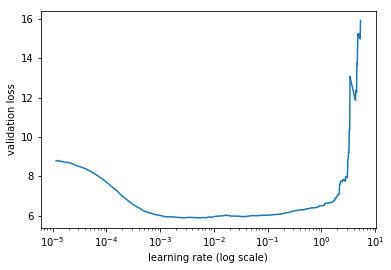

In [40]:
learn.sched.plot()

In [41]:
lr = 3e-4

In [42]:
sz = 64
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [43]:
learn.set_data(data)
learn.fit(lr, 6, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy num_accuracy 
    0      5.44552    5.376262   0.667365   0.051198  
    1      5.245513   5.242145   0.680988   0.066317         
    2      5.13995    5.178938   0.688024   0.067365         
    3      5.065736   5.116437   0.694162   0.076048         
    4      5.041922   5.086406   0.692066   0.077096         
    5      5.02349    5.051236   0.701198   0.081437         


[5.0512356494001285, 0.7011976441937292, 0.081437125748503]

In [44]:
lrs = np.array([lr/100,lr/10,lr])

In [45]:
learn.freeze_to(-2)

In [46]:
# lrf=learn.lr_find(lrs/1000)
# learn.sched.plot(1)

In [47]:
learn.fit(lrs, 6, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy num_accuracy 
    0      4.848542   4.855475   0.726347   0.101347  
    1      4.354222   4.349142   0.766018   0.163922         
    2      3.939732   3.9385     0.792066   0.229341         
    3      3.600649   3.707174   0.803443   0.269311         
    4      3.359674   3.529795   0.812275   0.299551         
    5      3.187194   3.432238   0.81512    0.316617         


[3.4322377122090963, 0.8151198093762655, 0.3166167664670659]

In [48]:
learn.unfreeze()

In [49]:
learn.fit(lrs, 6, cycle_len=2)

epoch      trn_loss   val_loss   custome_accuracy num_accuracy 
    0      3.328171   3.46082    0.805539   0.313024  
    1      2.89455    3.362236   0.817515   0.326497         
    2      2.976553   3.256301   0.819761   0.348503         
    3      2.566719   3.187043   0.829341   0.371407         
    4      2.71084    3.138989   0.823204   0.381737         
    5      2.327633   3.118803   0.827994   0.393114         
    6      2.446615   3.106668   0.832335   0.404192         
    7      2.057911   3.111659   0.825898   0.398653         
    8      2.191336   3.119343   0.828443   0.406737         
    9      1.873759   3.106153   0.834731   0.421108         
    10     2.030847   3.096269   0.837425   0.418563         
    11     1.666987   3.116823   0.832635   0.432186         


[3.116822791670611, 0.8326347789721574, 0.432185628742515]

In [50]:
learn.save('svhn_number_001_pool2')

In [51]:
learn.load('svhn_number_001_pool2')

In [53]:
sz = 128
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [54]:
learn.set_data(data)
learn.freeze()
learn.fit(lr, 6, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy num_accuracy 
    0      4.664215   4.413232   0.728443   0.179042  
    1      4.283682   4.110054   0.753743   0.214671         
    2      4.129343   3.956212   0.763623   0.235479         
    3      3.965568   3.871314   0.772904   0.252096         
    4      3.792803   3.797634   0.775898   0.263623         
    5      3.863385   3.753172   0.778593   0.271707         


[3.753171928628476, 0.7785928603596316, 0.2717065868263473]

In [55]:
learn.freeze_to(-2)
learn.fit(lrs, 6, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy num_accuracy 
    0      2.763689   2.600599   0.844761   0.479491  
    1      2.379344   2.34826    0.859431   0.530539         
    2      2.108574   2.234012   0.868413   0.550599         
    3      1.923675   2.17099    0.873353   0.563473         
    4      1.749598   2.15114    0.873204   0.569162         
    5      1.617463   2.137457   0.872006   0.578144         


[2.1374569422827507, 0.8720060379919178, 0.5781437125748503]

In [56]:
learn.unfreeze()
learn.fit(lrs, 6, cycle_len=2)

epoch      trn_loss   val_loss   custome_accuracy num_accuracy 
    0      1.742021   2.204006   0.867216   0.571108  
    1      1.408901   2.164867   0.873054   0.588174         
    2      1.472421   2.16894    0.877545   0.589521         
    3      1.14982    2.14038    0.878293   0.602545         
    4      1.295336   2.144971   0.87979    0.600599         
    5      1.008811   2.164742   0.880689   0.615719         
    6      1.156973   2.224929   0.868114   0.600449         
    7      0.8837     2.209705   0.879042   0.617066         
    8      1.004854   2.260796   0.875898   0.60988          
    9      0.773247   2.257555   0.878443   0.624102         
    10     0.883383   2.356939   0.876946   0.61482          
    11     0.683772   2.304683   0.881587   0.625449         


[2.304683142793393, 0.8815868753872945, 0.6254491017964072]

In [57]:
learn.save('svhn_number_002_pool2')

In [58]:
learn.load('svhn_number_002_pool2')

In [59]:
sz = 256
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [60]:
learn.set_data(data)
learn.freeze()
learn.fit(lr, 6, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy num_accuracy 
    0      3.311611   2.94007    0.817814   0.424102  
    1      2.981532   2.694676   0.831437   0.463772         
    2      2.756652   2.60112    0.84027    0.479341         
    3      2.641255   2.540798   0.844162   0.492066         
    4      2.565213   2.492255   0.84506    0.494461         
    5      2.507575   2.447306   0.848952   0.506587         


[2.4473061866745978, 0.8489521451874408, 0.5065868263473053]

In [61]:
learn.freeze_to(-2)
learn.fit(lrs, 6, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy num_accuracy 
    0      1.809669   1.797848   0.890569   0.637275  
    1      1.537768   1.678851   0.894761   0.669311         
    2      1.293265   1.646112   0.9        0.685928         
    3      1.223789   1.624433   0.902395   0.697305         
    4      1.079942   1.624637   0.89985    0.702246         
    5      0.972419   1.642337   0.902246   0.701347         


[1.6423371932999102, 0.9022455569691287, 0.7013473053892215]

In [62]:
learn.unfreeze()
learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)
learn.save('svhn_number_003_pool2')

epoch      trn_loss   val_loss   custome_accuracy num_accuracy 
    0      0.990746   1.684557   0.899102   0.702395  
    1      0.984262   1.689601   0.903144   0.704341         
    2      0.7744     1.661732   0.905539   0.717665         
    3      0.894717   1.760584   0.903892   0.704192         
    4      0.717772   1.741896   0.906587   0.723653         
    5      0.562206   1.718285   0.908533   0.731886         
    6      0.51789    1.716754   0.907934   0.735329         
    7      0.831475   1.903568   0.899252   0.696707         
    8      0.659901   1.842026   0.904341   0.717216         
    9      0.601435   1.882608   0.906287   0.731737         
    10     0.498568   1.829802   0.909731   0.738922         
    11     0.438016   1.783624   0.909281   0.740569         
    12     0.396509   1.793042   0.912126   0.752844         
    13     0.392356   1.778293   0.91512    0.754341         
    14     0.359959   1.777241   0.913473   0.753443         


In [63]:
learn.load('svhn_number_003_pool2')

In [64]:
learn.unfreeze()
learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)
learn.save('svhn_number_004_pool2')

epoch      trn_loss   val_loss   custome_accuracy num_accuracy 
    0      0.436746   1.831864   0.912725   0.748204  
    1      0.480721   1.90182    0.908533   0.741018         
    2      0.40406    1.833899   0.912126   0.755838         
    3      0.584112   1.960428   0.901497   0.727994         
    4      0.439916   1.930139   0.909431   0.748503         
    5      0.372262   1.88508    0.909581   0.751497         
    6      0.33938    1.855624   0.910629   0.753892         
    7      0.537609   1.979446   0.908383   0.736527         
    8      0.465351   1.996082   0.908084   0.748204         
    9      0.41596    1.979215   0.909731   0.747455         
    10     0.374588   1.951717   0.912874   0.758084         
    11     0.348119   1.953457   0.913922   0.760479         
    12     0.320503   1.910492   0.913473   0.765269         
    13     0.316004   1.914597   0.916916   0.768413         
    14     0.313825   1.893028   0.916018   0.768114         


In [65]:
learn.unfreeze()
learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)
learn.save('svhn_number_005_pool2')

epoch      trn_loss   val_loss   custome_accuracy num_accuracy 
    0      0.363742   1.927171   0.911976   0.761377  
    1      0.41563    2.025283   0.907784   0.750599         
    2      0.327922   1.952436   0.912126   0.761677         
    3      0.440798   2.054962   0.907335   0.740269         
    4      0.36662    1.943915   0.912275   0.755539         
    5      0.332618   1.920878   0.91527    0.763024         
    6      0.317808   1.960267   0.913174   0.766467         
    7      0.477519   2.006245   0.910329   0.747305         
    8      0.414914   2.009895   0.91003    0.749251         
    9      0.368952   2.064408   0.913773   0.757036         
    10     0.340145   2.0284     0.908234   0.76003          
    11     0.31307    1.967529   0.912575   0.768114         
    12     0.290917   1.979321   0.917216   0.772605         
    13     0.286429   1.964335   0.918264   0.775            
    14     0.288792   1.976186   0.917814   0.773054         


In [66]:
ls /fast/data/SVHN/models 

svhn_001.h5                     svhn_number_002_pool3.h5
svhn_001_resnet32.h5            svhn_number_003.h5
svhn_002.h5                     svhn_number_003_num_boost.h5
svhn_002_resnet32.h5            svhn_number_003_pool2_extra.h5
svhn_003.h5                     svhn_number_003_pool2.h5
svhn_003_resnet32.h5            svhn_number_003_pool3.h5
svhn_box_001.h5                 svhn_number_004.h5
svhn_box_002.h5                 svhn_number_004_num_boost.h5
svhn_box_003.h5                 svhn_number_004_pool2_extra.h5
svhn_box_004.h5                 svhn_number_004_pool2.h5
svhn_number_001.h5              svhn_number_004_pool3.h5
svhn_number_001_pool2.h5        svhn_number_005.h5
svhn_number_001_pool3.h5        svhn_number_005_num_boost.h5
svhn_number_002.h5              svhn_number_005_pool2.h5
svhn_number_002_pool2_extra.h5  svhn_number_005_pool3.h5
svhn_number_002_pool2.h5        tmp.h5


### Sumary
Add more information, numbers in images, and using pool(2,2) are improve accuracy of model.

But the accuracy of number detection is quite low. 

Let train this model on extra dataset to see what happen.